# Toolkit for doing astronomy in python
## Olivia Cooper
## May 2022

The following examples are routines that I use regularly in my research :-)

For the basics of python, check out my colleague and friend Jackie Champagne's tutorials [here](https://github.com/jbchampagne/pythontutorials)

In [1]:
# import the modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import astropy
from astropy.table import Table, QTable
from astropy.wcs import WCS
from astropy import units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.constants as cns
from astropy.cosmology import Planck15 as cosmo
from astropy.modeling import models
plt.style.use('cooper-paper.mplstyle')

### astropy fun with units!

`astropy` has a slick units package, which comes in handy for lots of calculations. Let's start with a simple example of setting and converting units.

In [2]:
# imagine some 3D object with the following dimensions

L = 0.27*u.km # length = 0.27 km
W = 1e-9*u.pc # width = 10^-9 pc
H = 5e8*u.micron # height = 5*10^8 micron

In [3]:
# now find the volume

vol = L*W*H
print(vol)

0.13500000000000004 km micron pc


I have no idea what a km micron pc is. Let's turn this into more useful units.

In [4]:
vol_km = vol.to(u.km**3)
vol_km

<Quantity 4165.66473501 km3>

(This is on the order of the volume of a neutron star!)

Sometimes doing math with astropy unit objects and regular floats gives you an error. To avoid this, give the unitless number some units, or call just the value of the astropy unit object.

In [6]:
some_number = 14.5 # a float
vol + some_number

UnitConversionError: Can only apply 'add' function to dimensionless quantities when other argument is not a quantity (unless the latter is all zero/infinity/nan)

In [8]:
# two options to avoid this issue

print(vol_km.value + some_number) # add just the values, but make sure YOU know the units
print(vol_km + some_number*u.km**3) # include some units

4180.164735013347
4180.164735013347 km3


Now you're equipped to do more involved calculations, such as the following, which I used this in my research! Note that this example also uses the cosmology and models features.

In [9]:
def gasmass(z,beta,lam,Slam,dSlam=None,tdust=25,CMBcorr=False):
    """
    Calculate gas mass for given parameters (see Scoville+2016, Casey+2019)
    
    
    INPUT:
        
        z = redshift
        
        beta = dust emissivity parameter
        
        lam = wavelength of photometric point [um]
        
        Slam = flux at lam [mJy]
        
        dSlam = (optional) flux error at lam [mJy]
            Default = None
            
        tdust = (optional) mass weighted dust temperature [K]
            Default = 25 [K]
            
        CMBcorr = (optional) CMB correction term (more relevant at high z, z > 5-6)
            Default = False
        
        
    OUTPUT:
    
        gasmass = estimated gas mass [Msun]
    
    """
    
    beta = beta
    
    # replace negative fluxes with 2-sigma values
    if Slam < 0:
        Slam = (2*dSlam)*u.mJy
    else:
        Slam = Slam*u.mJy
        
    S_nu_obs = Slam.to(u.erg/u.s/u.cm**2/u.Hz) # erg/s/cm2/Hz

    
    tdust = tdust*u.K  # mass weighted dust temp
    z = z

    dL = cosmo.luminosity_distance(z).to(u.cm)

    alpha = 6.7e19*u.erg/u.s/u.Hz/u.solMass # erg/s/Hz/Msun  +/- 1.7
    lam_obs = lam*u.um # um
    nu_obs = lam_obs.to(u.Hz, equivalencies=u.spectral())
    nu_rest = nu_obs*(1+z) # um
    nu_850 = (850*u.um).to(u.Hz, equivalencies=u.spectral()) 

    bb_td = models.BlackBody(temperature=tdust)
    bb_cmb = models.BlackBody(temperature=(cosmo.Tcmb0*((1+z)**(-1)))) 


    def gamma_rj(nu, tdust, z):
        h = cns.h.cgs
        k = cns.k_B.cgs
        tdust = tdust*u.K
        nu = nu*u.Hz
        num = h*nu*(1+z)/(k*tdust)
        denom = np.exp(num.value) - 1
        return num/denom

    gamma_rj_0 = gamma_rj(nu_850, tdust, 0) # is this right? nu_ref who
    gamma_rj = gamma_rj(nu_obs, tdust, z)

    term1 = (4*np.pi*S_nu_obs*(dL**2))/(alpha*((1+z)**(3+beta)))
    term2 = (nu_850/nu_obs)**(2+beta)
    term3 = (gamma_rj_0/gamma_rj)
    term4 = (1 - (bb_cmb(nu_rest))/(bb_td(nu_rest)))**(-1)
    
    # include (high-z) or exclude (low-z) CMB term
    if CMBcorr==True:
        gasmass = term1*term2*term3*term4
    else:
        gasmass = term1*term2*term3
    
    
    return gasmass

In [10]:
z = 3.2; beta = 2.0; lam = 2000; Slam = 0.5; dSlam = 0.08
gasmass(z,beta,lam,Slam,dSlam)

<Quantity 2.25284518e+11 solMass>

### reading in data

In almost every problem, you'll need to read in data. Often this will be in a simple format as a text file or a csv/tsv (comma/tab separated values). There's dozens of way to do this, some easier than others. Sometimes you need to add some extras to the command to get the table to look right when you load it. I'll demonstrate a few, but my go-to is astropy tables!

In [11]:
# name of an example data file, enter the full path if not in the same directory as the notebook

file = 'ssa22_coords_ocooper.txt'

In [12]:
# numpy...best if you have just floats! also will unpack the table into separate arrays

obj,ra,dec,pos = np.loadtxt(file, dtype={'names': ('obj', 'ra_deg', 'dec_deg', 'alma_position'),\
                        'formats': ('S8', 'float', 'float', 'int')}, skiprows=1, unpack=True)
obj

array([b'SSA.0001', b'SSA.0002', b'SSA.0003', b'SSA.0004', b'SSA.0005',
       b'SSA.0006', b'SSA.0007', b'SSA.0008', b'SSA.0009', b'SSA.0010',
       b'SSA.0011', b'SSA.0012', b'SSA.0013', b'SSA.0014', b'SSA.0015',
       b'SSA.0016', b'SSA.0017', b'SSA.0018', b'SSA.0019', b'SSA.0020',
       b'SSA.0021', b'SSA.0022', b'SSA.0023', b'SSA.0024', b'SSA.0025',
       b'SSA.0026', b'SSA.0027', b'SSA.0028', b'SSA.0029', b'SSA.0030',
       b'SSA.0031', b'SSA.0032', b'SSA.0033', b'SSA.0034', b'SSA.0035',
       b'SSA.0036', b'SSA.0037', b'SSA.0038', b'SSA.0041'], dtype='|S8')

In [13]:
# pandas...slick for csv but will work for txt if you give it a separator

pdtable = pd.read_csv(file, sep='\t+', engine='python')
pdtable

,obj,ra_deg,dec_deg,alma_position
0,SSA.0001,334.385029,0.295500,1
1,SSA.0002,334.231779,0.479472,1
2,SSA.0003,334.249850,0.177879,0
3,SSA.0004,334.213487,0.305750,1
4,SSA.0005,334.328737,0.301768,0
5,SSA.0006,334.527542,0.089056,1
6,SSA.0007,334.404250,0.306278,1
7,SSA.0008,334.526917,0.192917,1
8,SSA.0009,334.391363,0.231111,1
9,SSA.0010,334.254613,0.558722,1


In [14]:
# astropy tables...need to specify format but works for ascii,csv,fits,etc!

table = Table.read(file,format='ascii')
table.show_in_notebook()

idx,obj,ra_deg,dec_deg,alma_position
0,SSA.0001,334.3850292,0.2955,1
1,SSA.0002,334.2317792,0.479472222,1
2,SSA.0003,334.2498497,0.17787932,0
3,SSA.0004,334.2134875,0.30575,1
4,SSA.0005,334.3287375,0.30176828,0
5,SSA.0006,334.5275417,0.089055556,1
6,SSA.0007,334.40425,0.306277778,1
7,SSA.0008,334.5269167,0.192916667,1
8,SSA.0009,334.3913625,0.231111111,1
9,SSA.0010,334.2546125,0.558722222,1


In [15]:
# call certain columns, rows, objects by indexing

table['obj'][4]

'SSA.0005'

### crossmatching data sets and working with coordinates

The table we loaded in above has coordinates for a sample of galaxies. You're studying a galaxy, and want to see if your galaxy has a match in the literature sample. I do something like this in basically every project.

In [16]:
# define the coordinates for your galaxy and create an astropy SkyCoord object
# also create SkyCoord objects for the literature data

lit_coord = SkyCoord(table['ra_deg'],table['dec_deg'],unit='deg')
ra = 334.4044
dec = 0.3065
mygal = SkyCoord(ra,dec,unit='deg')

mygal

<SkyCoord (ICRS): (ra, dec) in deg
    (334.4044, 0.3065)>

In [17]:
# match the galaxy to the literature sample

idx, d2, d3 = mygal.match_to_catalog_3d(lit_coord)
idx

array(6)

In [18]:
# find which source that corresponds to in the literature data

table[6]

obj,ra_deg,dec_deg,alma_position
str8,float64,float64,int64
SSA.0007,334.40425,0.306277778,1


In [19]:
# how good is the match? check the 2D separation

d2.to(u.arcsec)

<Angle [0.9651893] arcsec>

### make regions file

It's a great idea to make your own scripts to ensure your work is reproducible! Check out the `makereg.py` file and see what it does. If a code has good documentation you can try executing the function followed by a `?`...otherwise just open the script itself in a text editor or in the jupyter notebook platform itself. Then try using it below:

In [20]:
# import our own script!

import makereg
# click x on the pop up after you're done reading!
makereg.table_to_reg?

In [21]:
makereg.table_to_reg(filepath=file,outname='ssa22_cooper',ra='ra_deg',dec='dec_deg')

     Wrote ds9 regions file  ssa22_cooper.reg
     To use in ds9: Regions > Load Regions > <filename> 



### plot images

Set OBSGEO-B to    19.822853 from OBSGEO-[XYZ].
Set OBSGEO-H to     4120.022 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


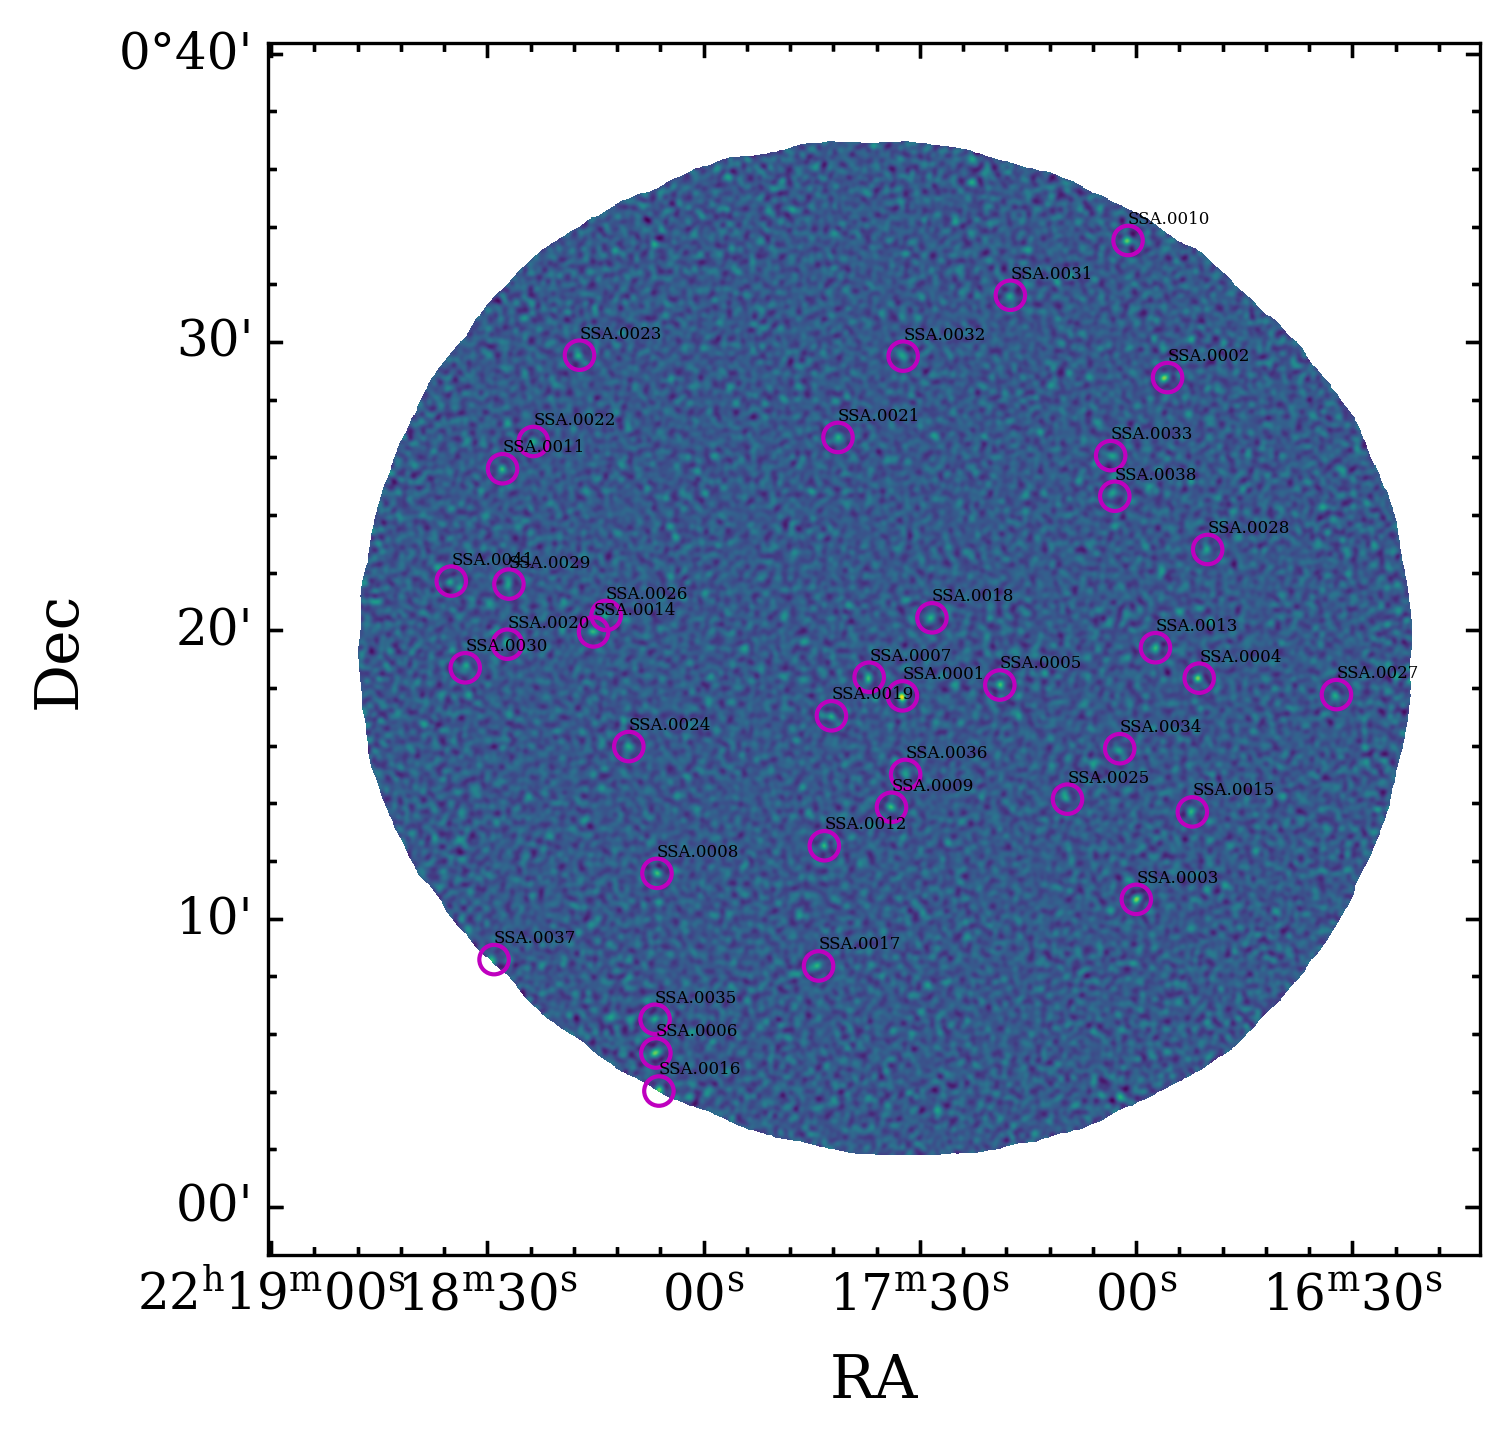

In [22]:
# let's plot the literature data over an image

img = 'S2CLS_SSA22_MF_FLUX_DR1.FITS'
im,hdr = fits.getdata(img, header=True)
wcs = WCS(hdr)

ax = plt.subplot(projection=wcs, slices=(['x', 'y', 0]))
plt.imshow(im,origin='lower')
ax.scatter(table['ra_deg'], table['dec_deg'], transform=ax.get_transform('fk5'), s=50, marker='o', \
               edgecolor='m',facecolor='none', lw=1, zorder=1)
for i in range(len(table['obj'])):
    plt.text(table['ra_deg'][i], table['dec_deg'][i]+0.01,table['obj'][i],color='k',\
             fontsize=4,transform=ax.get_transform('fk5'))         
plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(False)
plt.show()

### write out data

Alright. Now that we've done some calculations and made some crossmatches to literature data, let's make a new file for our data. Let's add a gas mass to our galaxy and include the source name in the literature catalog.

In [23]:
# initialize the table

gas = gasmass(z=z, beta=beta, lam=lam, Slam=Slam, dSlam=dSlam)
data = np.array([table['obj'][idx],mygal.ra,mygal.dec,gas])
newtab = Table(data,names=('ID','ra','dec','gasmass'))
newtab

ID,ra,dec,gasmass
str32,str32,str32,str32
SSA.0007,334.4044,0.3065,225284517816.39386


In [24]:
# write it out!

newtab.write('mygalaxy.txt',format='ascii')